数据聚合与分组操作

主要包括以下内容:

a）使用一个或多个键（以函数、数组或DF列名的形式）将pandas拆分成为多个块；

b） 计算组汇总信息，如：计数、平均值、平均偏差或用户自定的函数；

c）应用组内变换或其他操作，如标准化、线性回归、排位或者自己选择；

d）计算数据透视表和交叉表；

e）执行分位数分析和其他统计组分析

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_note_interactivity = "all"
%matplotlib inline


import os
import sys
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

第一部分：

1. GroupBy机制

核心与R相同，为：拆分-应用-联合（split-apply-combine）。操作对象可以是pandas中的Series、DataFrame或其他数据结构；

然后，根据指定的一个或多个*键*分离到各个组中；

分组操作后，一个函数可以应用到各个组中，产生新的值；

最后，所有函数的应用结果将会联合成为一个结果对象。

分组键可以是多种形式，并且不一定是完全相同的类型：

a）与需要分组的轴向长度一致的值列表或值数组；

b）DF的列名值；

c）可以将分组轴向上的值和分组名称相匹配的字典或Series；

d）可以在轴索引或索引中的单个标签上调用的函数。

In [2]:
df = pd.DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'],
                   'key2': ['one', 'two', 'one', 'two', 'one'],
                   'data1': np.random.randn(5),
                   'data2': np.random.randn(5)})

In [3]:
df

,data1,data2,key1,key2
0,0.504189,-0.997013,a,one
1,-0.505229,-0.617273,a,two
2,0.301553,0.173129,b,one
3,0.607956,-1.005269,b,two
4,1.400225,0.214183,a,one


In [9]:
grouped = df['data1'].groupby(df['key1'])
grouped
#grouped变量是一个groupby对象。

In [11]:
grouped.mean()
#注意，这个mean方法是GroupBy对象的方法。

key1
a    0.466395
b    0.454754
Name: data1, dtype: float64

df[['data1']]反回了一个Series，然后这个Series根据分组键（‘key1’）进行了聚合，并产生了一个新的Series，该Series使用key1列的唯一值作为索引。

In [12]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [13]:
means

key1  key2
a     one     0.952207
      two    -0.505229
b     one     0.301553
      two     0.607956
Name: data1, dtype: float64

In [15]:
means.unstack('key1')

key1,a,b
key2,,
one,0.952207,0.301553
two,-0.505229,0.607956


In [16]:
means.unstack(1)

key2,one,two
key1,,
a,0.952207,-0.505229
b,0.301553,0.607956


In [17]:
#分组键也可以是正确长度的任何数组
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
#相当于引入了两个新列给原来的df[‘data1’]使用进行分组，但列名尚未给定

In [18]:
df['data1'].groupby([states, years]).mean()

California  2005   -0.505229
            2006    0.301553
Ohio        2005    0.556072
            2006    1.400225
Name: data1, dtype: float64

In [21]:
df.groupby('key1').mean()
#非数值列key2因为无法被聚合，因而被自动忽略了

,data1,data2
key1,,
a,0.466395,-0.466701
b,0.454754,-0.416070


In [20]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.952207 -0.391415
     two  -0.505229 -0.617273
b    one   0.301553  0.173129
     two   0.607956 -1.005269

In [22]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

2. 遍历各个分组（GroupBy对象支持迭代）

这是一个非常重要的特性;

迭代后会生成一个*包含组名和数据块*的2维元组序列。

In [23]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0  0.504189 -0.997013    a  one
1 -0.505229 -0.617273    a  two
4  1.400225  0.214183    a  one
b
      data1     data2 key1 key2
2  0.301553  0.173129    b  one
3  0.607956 -1.005269    b  two


In [24]:
print(df)

      data1     data2 key1 key2
0  0.504189 -0.997013    a  one
1 -0.505229 -0.617273    a  two
2  0.301553  0.173129    b  one
3  0.607956 -1.005269    b  two
4  1.400225  0.214183    a  one


In [28]:
#元组里面是两层键的名称（组名）
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0  0.504189 -0.997013    a  one
4  1.400225  0.214183    a  one
('a', 'two')
      data1     data2 key1 key2
1 -0.505229 -0.617273    a  two
('b', 'one')
      data1     data2 key1 key2
2  0.301553  0.173129    b  one
('b', 'two')
      data1     data2 key1 key2
3  0.607956 -1.005269    b  two


练到这其实就很明了了，GroupBy对象其实是对组名（用户指定的键或多个键）以及数据块（Series或者DF）进行了元组型封装，且支持迭代，确切的说就是需要迭代或者应用函数来获取结果。

In [32]:
#比较简便的获取数据块的方法，非常优雅，需要记住

pieces = dict(list(df.groupby('key1')))
pieces['b']

,data1,data2,key1,key2
2,0.301553,0.173129,b,one
3,0.607956,-1.005269,b,two


In [40]:
#默认情况下groupby在axis=0的轴向上分组，同样支持在其他任意周向尚进行分组。

print(df.dtypes)
print(df.dtypes.ndim)
print(type(df.dtypes))

data1    float64
data2    float64
key1      object
key2      object
dtype: object
1
<class 'pandas.core.series.Series'>


In [41]:
grouped = df.groupby(df.dtypes.values, axis=1)

for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0  0.504189 -0.997013
1 -0.505229 -0.617273
2  0.301553  0.173129
3  0.607956 -1.005269
4  1.400225  0.214183
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


3. 选择一列或所有列的子集

将从DF创建的GroupBy对象用列名或列名数组进行索引时，会产生用于聚合的列子集的效果。

In [44]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

In [46]:
#是下面的语法糖
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

In [47]:
df['data1']

0    0.504189
1   -0.505229
2    0.301553
3    0.607956
4    1.400225
Name: data1, dtype: float64

In [48]:
df[['data1']]

,data1
0,0.504189
1,-0.505229
2,0.301553
3,0.607956
4,1.400225


In [50]:
print(type(df['data1']), type(df[['data1']]))

<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


In [51]:
#计算data2列的均值

df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one  -0.391415
     two  -0.617273
b    one   0.173129
     two  -1.005269

In [53]:
print(type(df.groupby(['key1', 'key2'])['data2'].mean()))
df.groupby(['key1', 'key2'])['data2'].mean()

<class 'pandas.core.series.Series'>


key1  key2
a     one    -0.391415
      two    -0.617273
b     one     0.173129
      two    -1.005269
Name: data2, dtype: float64

In [56]:
#如果传入的是列表或数组（例如：[[]]或者[arr]），则此索引操作分会的对象是分组的DF；如果只有单个列名作为标量传递，则为分组的Series：

s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [57]:
s_grouped.mean()

key1  key2
a     one    -0.391415
      two    -0.617273
b     one     0.173129
      two    -1.005269
Name: data2, dtype: float64

4. 使用字典或Series分组

In [64]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [65]:
people

,a,b,c,d,e
Joe,0.896851,-0.872164,1.045067,-0.697742,1.395431
Steve,-1.189468,-0.095414,-0.211270,1.055818,-1.612227
Wes,0.711719,-0.093408,-1.255368,-0.202707,0.471016
Jim,1.145319,-0.901825,0.692995,0.936908,1.642949
Travis,1.412536,0.612548,0.031828,0.552461,-1.405393


In [66]:
people.iloc[2:3, [1, 2]] = np.nan

In [67]:
people

,a,b,c,d,e
Joe,0.896851,-0.872164,1.045067,-0.697742,1.395431
Steve,-1.189468,-0.095414,-0.211270,1.055818,-1.612227
Wes,0.711719,NaN,NaN,-0.202707,0.471016
Jim,1.145319,-0.901825,0.692995,0.936908,1.642949
Travis,1.412536,0.612548,0.031828,0.552461,-1.405393


In [68]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f': 'orange'}

In [69]:
by_columns = people.groupby(mapping, axis=1)

In [70]:
by_columns.mean()

,blue,red
Joe,0.173662,0.473373
Steve,0.422274,-0.965703
Wes,-0.202707,0.591367
Jim,0.814951,0.628814
Travis,0.292144,0.206564


In [71]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [72]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


5. 使用函数分组

In [75]:
#作为分组键传递的函数将会按照每个索引值调用一次，同时返回值会被同坐分组名称。

In [78]:
people

,a,b,c,d,e
Joe,0.896851,-0.872164,1.045067,-0.697742,1.395431
Steve,-1.189468,-0.095414,-0.211270,1.055818,-1.612227
Wes,0.711719,NaN,NaN,-0.202707,0.471016
Jim,1.145319,-0.901825,0.692995,0.936908,1.642949
Travis,1.412536,0.612548,0.031828,0.552461,-1.405393


In [76]:
#用名字的长度来进行分组
people.groupby(len).sum()#名字的长度只有：3、5、6三种，分组后被列为键

,a,b,c,d,e
3,2.753889,-1.773989,1.738062,0.036458,3.509396
5,-1.189468,-0.095414,-0.211270,1.055818,-1.612227
6,1.412536,0.612548,0.031828,0.552461,-1.405393


In [82]:
#将函数与数组、字典亦或Series进行混合不难，所有的对象在内部都会转换为数组。

In [83]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.711719 -0.872164  1.045067 -0.697742  0.471016
  two  1.145319 -0.901825  0.692995  0.936908  1.642949
5 one -1.189468 -0.095414 -0.211270  1.055818 -1.612227
6 two  1.412536  0.612548  0.031828  0.552461 -1.405393

6. 根据索引层级进行分组

In [84]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                     names=['cty', 'tenor'])

In [85]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [86]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.035298 -0.278056  0.959232  0.887179 -0.204703
1     -0.901569 -0.604162 -0.375953  1.287564  0.943650
2      1.115179 -0.808374  0.352363  1.056860 -0.973463
3      0.970154  0.677732  0.340757 -0.142020 -0.645718

In [87]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


第二部分：

1. 数据聚合

聚合是指所有根据数组产生标量值的数据转换过程。

优化的groupby方法：

count————非NA值的数量

sum

mean

median

std、var

min、max

prod

first、last————非NA值的第一个和最后一个值

In [88]:
df

,data1,data2,key1,key2
0,0.504189,-0.997013,a,one
1,-0.505229,-0.617273,a,two
2,0.301553,0.173129,b,one
3,0.607956,-1.005269,b,two
4,1.400225,0.214183,a,one


In [90]:
grouped = df.groupby('key1')

In [91]:
grouped['data1'].quantile(0.9)

key1
a    1.221018
b    0.577315
Name: data1, dtype: float64

In [92]:
#自定义聚合函数

def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.905454,1.211196
b,0.306403,1.178398


In [121]:
grouped.describe()


data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.466395 -0.466701
     std    0.953289  0.619478
     min   -0.505229 -0.997013
     25%   -0.000520 -0.807143
     50%    0.504189 -0.617273
     75%    0.952207 -0.201545
     max    1.400225  0.214183
b    count  2.000000  2.000000
     mean   0.454754 -0.416070
     std    0.216659  0.833253
     min    0.301553 -1.005269
     25%    0.378154 -0.710670
     50%    0.454754 -0.416070
     75%    0.531355 -0.121471
     max    0.607956  0.173129

逐列及多函数应用

In [122]:
tips = pd.read_csv('code/examples/tips.csv')

In [124]:
#添加总账单的小费比例
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


In [125]:
grouped = tips.groupby(['day', 'smoker'])

In [127]:
grouped_pct = grouped['tip_pct']
grouped_pct.mean()

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [128]:
#或者使用aggregate或agg方法，并向其指定聚合函数
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [131]:
#如果传递的是函数或者函数名列表，则会获得一个列名为这些函数名的DF；
grouped_pct.agg(['mean', 'std' , peak_to_peak])
#传递了聚合函数的列表给agg方法，这些函数会各自运用于数据分组。

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

In [133]:
#利用二元组来建立列于函数的映射关系

grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [134]:
#可以指定应用到所有列上的函数列表或每一个列上要应用的不同函数
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [135]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [136]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

In [137]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

In [138]:
#将不同的函数应用到一个或多个列上

In [139]:
grouped.agg({'tip' : 'max', 'size' : 'sum'})

size    tip
day  smoker             
Fri  No         9   3.50
     Yes       31   4.73
Sat  No       115   9.00
     Yes      104  10.00
Sun  No       167   6.00
     Yes       49   6.50
Thur No       112   6.70
     Yes       40   5.00

In [141]:
#只有多个函数应用于至少一个列是，DF才具有分层列
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'], 'size': 'sum'})

size   tip_pct                              
             sum       min       max      mean       std
day  smoker                                             
Fri  No        9  0.120385  0.187735  0.151650  0.028123
     Yes      31  0.103555  0.263480  0.174783  0.051293
Sat  No      115  0.056797  0.291990  0.158048  0.039767
     Yes     104  0.035638  0.325733  0.147906  0.061375
Sun  No      167  0.059447  0.252672  0.160113  0.042347
     Yes      49  0.065660  0.710345  0.187250  0.154134
Thur No      112  0.072961  0.266312  0.160298  0.038774
     Yes      40  0.090014  0.241255  0.163863  0.039389

2. 返回不含行索引的聚合数据

In [143]:
#前面的例子中，聚合数据返回是都是带有索引的，有时索引是分层的，由唯一的分组键联合形成。
#大多数情况下可以通过向groupby传递as_index=False来禁用分组键作为索引的行为。
tips.groupby(['day', 'smoker'], as_index=False).mean()

#其实可以理解为按照长列表返回结果

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


In [144]:
#通过调用reset_index()可以获得与as_index=False相同的效果。

第三部分：应用：通用拆分——应用——联合

GroupBy方法最最最为常见的目的是apply（应用）；

*apply*将数据对象拆分成多个块，然后在每一个块上调用传递的函数，之后尝试将每一个块拼接到一起。

In [145]:
#练习，小费数据集，选出小费百分比(tip_pct)最高的五组

In [146]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [147]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [148]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

原理解释：top函数在DF的每一行分组上被调用，之后使用pandas.concat将函数结果粘贴在了一起，并使用分组名作为各组的名标签。

因此，结果包含一个分层索引，该分层索引的内部层级包含原始DF的索引值。

In [150]:
#被传递函数所需的额外参数可以在被传递的函数外（作为apply函数的可选参数）传递

tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

被传递函数的构建需要coder有些想象力，内部实现没有限制，只需要函数能返回一个pandas对象或者一个标量值。

In [151]:
result = tips.groupby('smoker')['tip_pct'].describe()

In [152]:
result

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
Name: tip_pct, dtype: float64

In [153]:
result.unstack('smoker')

smoker,No,Yes
count,151.000000,93.000000
mean,0.159328,0.163196
std,0.039910,0.085119
min,0.056797,0.035638
25%,0.136906,0.106771
50%,0.155625,0.153846
75%,0.185014,0.195059
max,0.291990,0.710345


In [154]:
#实际上，在GroupBy对象的内部，当调用describe之类的方法时，实际上是一下代码的简写：
'''
f = lambda x: x.describe()
grouped.apply(f)
'''

'\nf = lambda x: x.describe()\ngrouped.apply(f)\n'

下面是利用groupby解决实际数据分析问题的例子:

练习一：压缩分组键

In [155]:
tips.groupby('smoker', group_keys=False).apply(top) #top函数的声明在前面

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [157]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


练习二：分位数与捅分析

pandas中有一些工具，尤其是cut和qcut，用于将数据按照用户指定的箱位或样本分位数进行分桶（分段）。

In [158]:
frame = pd.DataFrame({'data1' : np.random.randn(1000),
                      'data2' : np.random.randn(1000)})

In [164]:
frame.head()

,data1,data2
0,-0.347798,-0.548535
1,1.436589,0.462564
2,-0.912868,0.616846
3,-0.205733,-0.116228
4,-0.693465,-0.172891


In [161]:
quartiles = pd.cut(frame.data1, 4)

In [162]:
quartiles[:10]

0     (-0.365, 1.436]
1      (1.436, 3.237]
2    (-2.166, -0.365]
3     (-0.365, 1.436]
4    (-2.166, -0.365]
5     (-0.365, 1.436]
6      (1.436, 3.237]
7     (-0.365, 1.436]
8     (-0.365, 1.436]
9    (-2.166, -0.365]
Name: data1, dtype: category
Categories (4, object): [(-3.974, -2.166] < (-2.166, -0.365] < (-0.365, 1.436] < (1.436, 3.237]]

In [165]:
#cut返回的Categorical对象可以直接传递给groupby
#复习：cut是等长分割，qcut是等分位分割。

In [166]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

In [167]:
grouped = frame.data2.groupby(quartiles)

In [169]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.974, -2.166]",14.0,1.540460,0.151988,-1.018752
"(-2.166, -0.365]",356.0,3.302602,0.037944,-3.396418
"(-0.365, 1.436]",557.0,3.671879,-0.034799,-3.747371
"(1.436, 3.237]",73.0,1.924645,0.013457,-3.140200


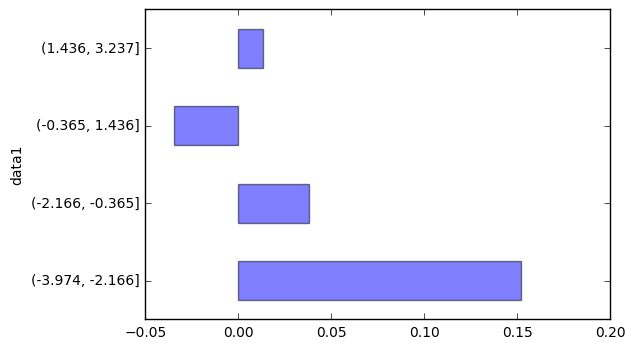

In [175]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
resdf = grouped.apply(get_stats).unstack()
resdf['mean'].plot(ax=ax, kind='barh', alpha=0.5)

In [176]:
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.369492,-0.074233,-3.134849
1,100.0,3.302602,0.198347,-2.065140
2,100.0,2.117440,0.132791,-3.396418
3,100.0,2.124982,-0.171468,-2.361442
4,100.0,3.671879,-0.193965,-2.840238
5,100.0,2.473653,-0.011509,-2.744353
6,100.0,2.699061,0.034029,-2.430826
7,100.0,2.828798,0.057472,-3.747371
8,100.0,2.970448,-0.041068,-2.356199


In [177]:
grouping = pd.qcut(frame.data1, 10)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"[-3.967, -1.235]",100.0,2.369492,-0.074233,-3.134849
"(-1.235, -0.852]",100.0,3.302602,0.198347,-2.065140
"(-0.852, -0.522]",100.0,2.117440,0.132791,-3.396418
"(-0.522, -0.289]",100.0,2.124982,-0.171468,-2.361442
"(-0.289, -0.0065]",100.0,3.671879,-0.193965,-2.840238
"(-0.0065, 0.246]",100.0,2.473653,-0.011509,-2.744353
"(0.246, 0.514]",100.0,2.699061,0.034029,-2.430826
"(0.514, 0.868]",100.0,2.828798,0.057472,-3.747371
"(0.868, 1.334]",100.0,2.970448,-0.041068,-2.356199


练习三：使用指定分组值填充缺失值

In [178]:
#使用dropna来去除缺失值；使用fillna来填充缺失值（甚至可以指定用户想填充的值）

In [179]:
s = pd.Series(np.random.randn(6))

In [180]:
s[::2] = np.nan

In [181]:
s

0         NaN
1    1.733372
2         NaN
3   -0.207811
4         NaN
5   -0.359610
dtype: float64

In [182]:
s.fillna(s.mean())

0    0.388650
1    1.733372
2    0.388650
3   -0.207811
4    0.388650
5   -0.359610
dtype: float64

In [183]:
#下面看看填充值按组变化

In [185]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'Califonia', 'Idaho']

In [189]:
group_key = ['east'] * 4 + ['west'] * 4
data = pd.Series(np.random.randn(8), index=states)
data

Ohio        -1.068703
New York    -0.378691
Vermont     -0.629795
Florida      0.657255
Oregon      -0.124613
Nevada      -0.670289
Califonia   -0.221545
Idaho        0.341726
dtype: float64

In [190]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

In [191]:
data.groupby(group_key).mean()

east   -0.263380
west   -0.173079
dtype: float64

In [192]:
fill_mean = lambda g: g.fillna(g.mean())

In [193]:
data.groupby(group_key).apply(fill_mean)

Ohio        -1.068703
New York    -0.378691
Vermont     -0.263380
Florida      0.657255
Oregon      -0.124613
Nevada      -0.173079
Califonia   -0.221545
Idaho       -0.173079
dtype: float64

In [194]:
#在预定义填充值的情况下可以这么使

In [195]:
fill_values = {'east': 0.5, 'west': -1}

In [196]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [198]:
data.groupby(group_key).apply(fill_func)

Ohio        -1.068703
New York    -0.378691
Vermont      0.500000
Florida      0.657255
Oregon      -0.124613
Nevada      -1.000000
Califonia   -0.221545
Idaho       -1.000000
dtype: float64

练习四：随机采样及排列

In [199]:
#从大样本中抽取随机样本

In [204]:
#红桃，黑桃，梅花，方块
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
#获得了52张牌
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)
deck = pd.Series(card_val, index=cards)

In [205]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [206]:
def draw(deck, n=5):
    return deck.sample(n)
draw(deck)

JS    10
6S     6
6H     6
KH    10
7C     7
dtype: int64

In [207]:
get_suit = lambda card: card[-1]
deck.groupby(get_suit).apply(draw, 2)

C  JC    10
   QC    10
D  QD    10
   JD    10
H  AH     1
   7H     7
S  8S     8
   4S     4
dtype: int64

In [208]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

3C     3
QC    10
QD    10
KD    10
8H     8
6H     6
5S     5
7S     7
dtype: int64

练习五：分组加权平均和相关性

In [209]:
#在groupby的拆分-应用-联合（SAC）范式下，df的列检操作或两个Series之间的操作，例如分组加权平均是完全可以的。

In [211]:
df = pd.DataFrame({'category': ['a'] * 4 +['b'] * 4, 'data': np.random.randn(8), 'weights': np.random.rand(8)})

In [213]:
df

,category,data,weights
0,a,-0.467270,0.860739
1,a,0.100184,0.535091
2,a,0.663233,0.747767
3,a,-0.343500,0.735823
4,b,-0.905318,0.309188
5,b,-2.652765,0.364701
6,b,-0.109785,0.307959
7,b,1.954761,0.177677


In [214]:
grouped = df.groupby('category')

In [215]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [216]:
grouped.apply(get_wavg)

category
a   -0.036605
b   -0.805393
dtype: float64

In [217]:
#雅虎财经数据集，包括一些标普500（SPX）和股票的收盘价

In [218]:
close_px = pd.read_csv('code/examples/stock_px_2.csv', parse_dates=True, index_col=0)

In [219]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [226]:
close_px.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2011-10-03', '2011-10-04', '2011-10-05', '2011-10-06',
               '2011-10-07', '2011-10-10', '2011-10-11', '2011-10-12',
               '2011-10-13', '2011-10-14'],
              dtype='datetime64[ns]', length=2214, freq=None)

In [220]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


In [221]:
#计算标普指数（SPX）每日受益的年度相关性（通过百分比变化计算）

In [222]:
spx_corr = lambda x: x.corrwith(x.SPX)

In [224]:
rets = close_px.pct_change().dropna()
rets.head()

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386


In [225]:
get_year = lambda x: x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [227]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

练习六：逐组线性回归

In [229]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [ ]:
by_year.apply(regress, 'AAPL', ['SPX'])

总结：精通pandas数据分组工具既可以帮助用户清洗数据，也可以对建模或同级分析工作有益。因此，必须熟练掌握。